# Análise da base Airbnb

Autor: Fernando Neves Quintino dos Santos

In [765]:
import os
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import nltk

import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from matplotlib.colors import rgb2hex

from itertools import chain

from branca.colormap import linear, LinearColormap
from statsmodels.formula.api import ols
from IPython.display import Markdown, IFrame

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import GammaRegressor
from sklearn.metrics import mean_squared_error, mean_gamma_deviance, mean_absolute_percentage_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from lightgbm import LGBMRegressor

from scipy.stats import expon

# A predição do preço foi escolhida para modelagem

## Bases

Existem 5 diferentes bases, mas a base lisitings é a mais completa enquanto as outras possuem poucas informações. Apenas ela será utilizada.

### Base listings

In [766]:
listings=pd.read_csv('http://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2020-12-23/data/listings.csv.gz')

In [768]:
listings.head(3)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,17878,https://www.airbnb.com/rooms/17878,20201223235510,2020-12-30,"Very Nice 2Br in Copacabana w. balcony, fast WiFi",Discounts for long term stays. <br />- Large b...,This is the one of the bests spots in Rio. Bec...,https://a0.muscache.com/pictures/65320518/3069...,68997,https://www.airbnb.com/users/show/68997,...,10.0,10.0,9.0,NaN,t,1,1,0,0,2.03
1,25026,https://www.airbnb.com/rooms/25026,20201223235510,2020-12-24,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",Copacabana is a lively neighborhood and the ap...,https://a0.muscache.com/pictures/3003965/68ebb...,3746246,https://www.airbnb.com/users/show/3746246,...,10.0,10.0,9.0,NaN,f,11,11,0,0,1.85
2,35636,https://www.airbnb.com/rooms/35636,20201223235510,2020-12-24,Cosy flat close to Ipanema beach,This cosy apartment is just a few steps away ...,The apartment street is very quiet and safe ....,https://a0.muscache.com/pictures/20009355/38b6...,153232,https://www.airbnb.com/users/show/153232,...,10.0,10.0,9.0,NaN,f,1,1,0,0,2.07


In [769]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25784 entries, 0 to 25783
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            25784 non-null  int64  
 1   listing_url                                   25784 non-null  object 
 2   scrape_id                                     25784 non-null  int64  
 3   last_scraped                                  25784 non-null  object 
 4   name                                          25755 non-null  object 
 5   description                                   24423 non-null  object 
 6   neighborhood_overview                         14109 non-null  object 
 7   picture_url                                   25784 non-null  object 
 8   host_id                                       25784 non-null  int64  
 9   host_url                                      25784 non-null 

### Variáveis de interesse:

Diversas variáveis podem influir no preço, mas apenas algumas foram selecionadas numa tentativa de simplificar a modelagem. Essa triagem foi feita pela experiência do autor. Ex. número de banheiros é mais relevante na montagem do preço do que se o host tem foto.

Lista de variáveis escolhidas:

* bathrooms_text
* property_type
* room_type
* host_verifications
* accommodates
* amenities
* minimum_nights
* maximum_nights
* minimum_minimum_nights
* maximum_minimum_nights
* minimum_maximum_nights
* maximum_maximum_nights
* minimum_nights_avg_ntm
* maximum_nights_avg_ntm
* calculated_host_listings_count
* calculated_host_listings_count_entire_homes
* calculated_host_listings_count_private_rooms
* calculated_host_listings_count_shared_rooms
* reviews_per_month
* has_availability
* availability_30
* availability_60
* availability_90
* availability_365

In [770]:
listings_red=listings.iloc[:,[29,30,31,32,33,35,36,37,38,39,50,51,52,53,73]]

In [771]:
listings_red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25784 entries, 0 to 25783
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   latitude           25784 non-null  float64
 1   longitude          25784 non-null  float64
 2   property_type      25784 non-null  object 
 3   room_type          25784 non-null  object 
 4   accommodates       25784 non-null  int64  
 5   bathrooms_text     25714 non-null  object 
 6   bedrooms           24058 non-null  float64
 7   beds               25546 non-null  float64
 8   amenities          25784 non-null  object 
 9   price              25784 non-null  object 
 10  availability_30    25784 non-null  int64  
 11  availability_60    25784 non-null  int64  
 12  availability_90    25784 non-null  int64  
 13  availability_365   25784 non-null  int64  
 14  reviews_per_month  15852 non-null  float64
dtypes: float64(5), int64(5), object(5)
memory usage: 3.0+ MB


# Tratamento das variáveis numéricas

## Variável preço

### Conversão em variável numérica

In [772]:
listings_red['price']=listings_red['price'].str.replace('[$,]','').astype(float)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Verificação de outliers

Criação da variável preço por pessoa, que é uma métrica mais verossímel para algumas análises.

In [773]:
listings_red['price_person']=listings_red['price'].div(listings_red['accommodates'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [774]:
listings_red.price_person.quantile(.25)

66.66666666666667

In [775]:
listings_red.price_person.quantile(.75)

188.0

In [776]:
listings_red.price_person.max()

118653.2

Aparentemente existem valores estranhos. Eles serão filtrados usando tuckey fences.

In [777]:
q_low=listings_red["price_person"].quantile(0.25)
q_hi=listings_red["price_person"].quantile(0.75)
iqr=q_hi-q_low

list_o=listings_red[((listings_red['price_person']) > (q_low-iqr)) & ((listings_red['price_person']) < (q_hi+iqr))]

Variável list_o criada contemplando os dados sem outliers

In [778]:
list_o.price.max()

4643.0

In [779]:
i_i,z=list_o.shape

In [780]:
i_o,z=listings_red.shape

In [781]:
1-i_i/i_o

0.10715947874650944

Apenas 10.7 % dos dados foram perdidos, o que não justificar imputar tais dados.

In [782]:
list_o.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23021 entries, 0 to 25783
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   latitude           23021 non-null  float64
 1   longitude          23021 non-null  float64
 2   property_type      23021 non-null  object 
 3   room_type          23021 non-null  object 
 4   accommodates       23021 non-null  int64  
 5   bathrooms_text     22974 non-null  object 
 6   bedrooms           21407 non-null  float64
 7   beds               22814 non-null  float64
 8   amenities          23021 non-null  object 
 9   price              23021 non-null  float64
 10  availability_30    23021 non-null  int64  
 11  availability_60    23021 non-null  int64  
 12  availability_90    23021 non-null  int64  
 13  availability_365   23021 non-null  int64  
 14  reviews_per_month  14935 non-null  float64
 15  price_person       23021 non-null  float64
dtypes: float64(7), int64(5

## Variável banheiro

### Conversão em variável numérica

In [783]:
list_o.bathrooms_text.head(8)

0            1 bath
1            1 bath
2         1.5 baths
3            1 bath
4            1 bath
6    1 private bath
7         3.5 baths
8            1 bath
Name: bathrooms_text, dtype: object

In [784]:
list_o.bathrooms_text.describe()

count      22974
unique        44
top       1 bath
freq        9523
Name: bathrooms_text, dtype: object

A variável banheiro é um objeto com 44 categorias. No tratamento o valor numérico será considerado.

In [785]:
baths = list_o['bathrooms_text'].value_counts().to_frame()

In [786]:
baths['baths'] = baths.index.str.extract('([0-9\.]{1,3}[0-9]?)').values

In [787]:
list_o['baths'] = list_o['bathrooms_text'].map(baths['baths'].to_dict()).astype(float)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Verificação de outliers

In [788]:
list_o['baths'].min()

0.0

In [789]:
list_o['baths'].max()

20.0

Aparentemente não há outliers na variável baths.

In [790]:
list_o.drop('bathrooms_text',axis=1,inplace=True)

C:\Users\fernando\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# Definição de novas variáveis

Além do preço por pessoa (price_person), é interessante calcular quartos, camas e banheiros por pessoa.

In [791]:
list_f['bedrooms_person']=list_f['bedrooms'].div(list_f['accommodates'])
list_f['beds_person']=list_f['beds'].div(list_f['accommodates'])
list_f['baths_person']=list_f['baths'].div(list_f['accommodates'])

In [792]:
list_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23021 entries, 0 to 25783
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   latitude                 23021 non-null  float64
 1   longitude                23021 non-null  float64
 2   property_type            23021 non-null  object 
 3   room_type                23021 non-null  object 
 4   accommodates             23021 non-null  int64  
 5   bedrooms                 23021 non-null  float64
 6   beds                     23021 non-null  float64
 7   amenities                23021 non-null  object 
 8   price                    23021 non-null  float64
 9   availability_30          23021 non-null  int64  
 10  availability_60          23021 non-null  int64  
 11  availability_90          23021 non-null  int64  
 12  availability_365         23021 non-null  int64  
 13  reviews_per_month        23021 non-null  float64
 14  price_person          

# Investigando correlação

O preço por pessoa foi retirado, pois ele tem a variável resposta na constituinte.

In [793]:
var=['latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bedrooms',
 'beds',
 'amenities',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'reviews_per_month',
 'baths',
 'bedrooms_person',
 'beds_person',
 'baths_person']

In [794]:
corr=list_f[['price']+var].select_dtypes('number').corr()

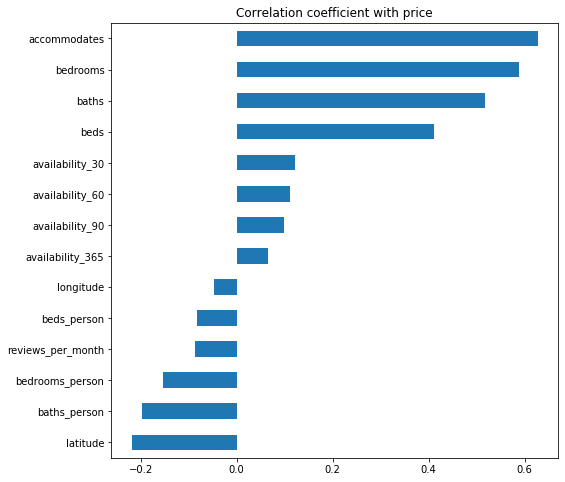

In [795]:
plt.figure(figsize=(8,8))
corr['price'].drop('price').sort_values().plot(kind='barh',title='Correlation coefficient with price')

Variáveis de que correlacionam com o tamanho do imóvel (número max. de pessoas, quartos, camas, banheiros), tem forte correlação com o preço. Isso é esperado pois de modo geral, quanto maior e mais confortável o local, maior o preço.

A variável reviews por mês tem correlação negativa pois em geral as pessoas só as fazem quando é para apontar defeitos.

As variáveis por pessoa afetam negativamente o preço, pois a variável de número máximo de pessoas tem correlação maior. Isso também pode ser entendido pensando que o número de quartos, banheiros, camas por pessoa só são realmente relevantes para imóveis pequenos. Em casos de acomodações maiores, estes números não são tão importantes como o número máximo de pessoas.

# Tratamento de variáveis categóricas

## Tipos de locação

In [796]:
list_f.room_type.describe()

count               23021
unique                  4
top       Entire home/apt
freq                16420
Name: room_type, dtype: object

In [797]:
list_f.room_type.unique()

array(['Entire home/apt', 'Private room', 'Shared room', 'Hotel room'],
      dtype=object)

Essa variável é categórica, com apenas quatro categorias. Será avaliado se essa divisão tem relevância estatística com o preço.

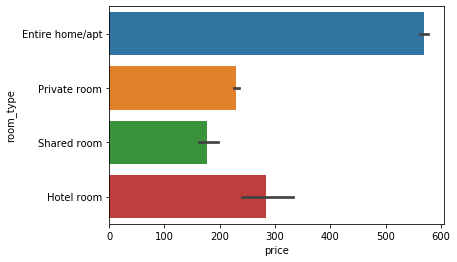

In [798]:
sns.barplot(x='price',y='room_type',data=list_f,orient='h')

Nota-se que cada tipo de locação possui uma faixa de preços diferente. O aluguel de uma casa ou apartamento é a categoria mais cara, até porque nesses casos vão mais pessoas. O quarto de hotel é mais caro que um quarto privado, pois em geral hóteis tem um serviço diferenciado, além de mais funcionários, o que eleva o preço por pessoa.

## Tipos de propriedade

In [799]:
list_f.property_type.describe()

count                23021
unique                  82
top       Entire apartment
freq                 13117
Name: property_type, dtype: object

In [800]:
list_f.property_type.unique()

array(['Entire condominium', 'Entire apartment', 'Entire loft',
       'Private room in apartment', 'Entire house',
       'Private room in bed and breakfast', 'Entire townhouse',
       'Private room in guest suite', 'Shared room in hostel',
       'Private room in house', 'Earth house',
       'Private room in condominium', 'Entire guest suite',
       'Entire guesthouse', 'Private room in loft', 'Room in hostel',
       'Private room in chalet', 'Entire place',
       'Entire serviced apartment', 'Entire chalet', 'Entire bungalow',
       'Room in boutique hotel', 'Private room in guesthouse',
       'Shared room in apartment', 'Private room', 'Shared room in house',
       'Private room in earth house', 'Entire hostel',
       'Private room in hostel', 'Private room in townhouse',
       'Private room in tiny house', 'Entire cottage', 'Treehouse',
       'Room in serviced apartment', 'Private room in villa',
       'Shared room', 'Room in aparthotel', 'Entire villa',
       'Shared

O tipo de propriedade é uma variável categórica, mas a cardinalidade é muito alta. Assim, faz sentido englobar em única categoria os tipos com menor participação.

In [801]:
k_idx=(list_f.loc[:, 'property_type'].value_counts(normalize=True).cumsum().to_frame().query('property_type < 0.9' ))
list_f['property_type_collapsed']=list_f['property_type']
mask=~list_f['property_type_collapsed'].isin(k_idx.index)
list_f.loc[mask,'property_type_collapsed']='Others'
order_idx=(list_f.groupby(['property_type_collapsed'])['price'].mean().sort_values(ascending=False).index);

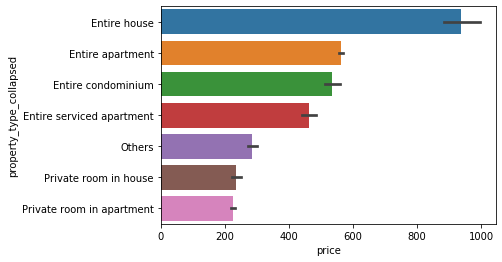

In [802]:
sns.barplot(x='price', y='property_type_collapsed', data=list_f, order=order_idx, orient='h')

Pelo gráfico existe relevância estatística entre cada tipo de propriedade.

## Facilidades

In [803]:
list_f.amenities.head(3)

0    [Hot water, Essentials, Stove, Microwave, Buil...
1    [TV, Cable TV, Elevator, Essentials, Iron, Bed...
2    [Elevator, Microwave, Essentials, Kitchen, Sto...
Name: amenities, dtype: object

Cada imóvel possui um conjunto diferente de facilidades. Ao invés de usar cada conjunto, é mais interessante valorar cada uma das facilidades individualmente.

In [804]:
(list_f.loc[:,'amenities'].explode().nunique())

557

In [805]:
relevant_amenities=(list_f.loc[:, 'amenities'].explode().value_counts(normalize=True, ascending=False).head(15))
relevant_amenities.cumsum().map('{:,.2%}'.format)

Kitchen                   5.32%
Wifi                     10.54%
Essentials               15.56%
TV                       20.43%
Air conditioning         25.03%
Hangers                  29.10%
Iron                     32.95%
Washer                   36.63%
Elevator                 40.24%
Hot water                43.71%
Dedicated workspace      47.12%
Dishes and silverware    49.94%
Refrigerator             52.48%
Hair dryer               54.85%
Microwave                57.21%
Name: amenities, dtype: object

# Modelagem

Text(0.5, 1.0, 'Price Distribution Truncated at R$ 10000')

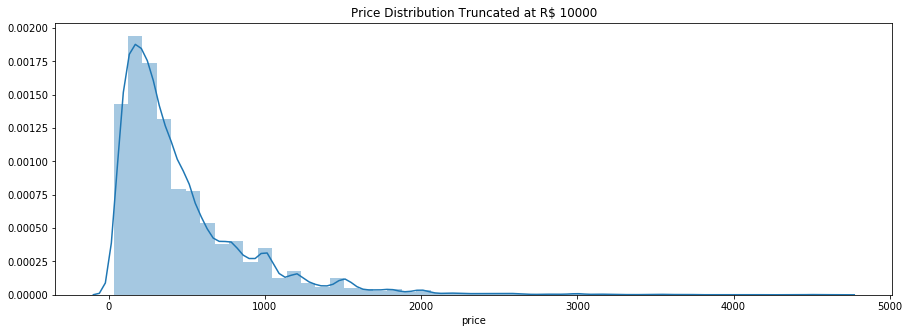

In [806]:
plt.figure(figsize=(15,5))
sns.distplot(list_f.price.clip(upper=10000))
plt.title('Price Distribution Truncated at R$ 10000')

A distribuição acima é gamma.

A modelagem será feita considerando um número de variáveis reduzido. Isso torna o modelo mais simplicado é interessante pela facilidade de interpretação. As variáveis escolhidas são:

* latitude
* longitude
* room_type
* accommodates
* bedrooms
* beds
* reviews_per_month
* baths
* property_type_collapsed

As variáveis geográficas latitude e longitude são interessantes pois representam os bairros. De modo geral, bairros mais caros tem locações mais caras.

As variáveis por pessoa foram excluídas pois ficam redundantes numa regressão com suas constituintes.

As facilidades são um parâmetro relevante, mas por ter uma cardinalidade muito alta, foram descartados em favor de variáveis mais significativas.

A disponibilidade foi descartada pelo mesmo motivo das facilidades. A idéia é simplificar o modelo.

In [807]:
list(list_f.columns)

['latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bedrooms',
 'beds',
 'amenities',
 'price',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'reviews_per_month',
 'price_person',
 'baths',
 'bedrooms_person',
 'beds_person',
 'baths_person',
 'property_type_collapsed']

In [808]:
df=list_f.iloc[:,[0,1,3,4,5,6,8,13,15,19]]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23021 entries, 0 to 25783
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   latitude                 23021 non-null  float64
 1   longitude                23021 non-null  float64
 2   room_type                23021 non-null  object 
 3   accommodates             23021 non-null  int64  
 4   bedrooms                 23021 non-null  float64
 5   beds                     23021 non-null  float64
 6   price                    23021 non-null  float64
 7   reviews_per_month        23021 non-null  float64
 8   baths                    23021 non-null  float64
 9   property_type_collapsed  23021 non-null  object 
dtypes: float64(7), int64(1), object(2)
memory usage: 2.4+ MB


## Criação das dummies

In [809]:
df=pd.get_dummies(df)

## Divisão da base

In [810]:
X=df.drop(columns='price')
y= df[['price']]
x_train,x_hold,y_train,y_hold=train_test_split(X, y, test_size=0.2)
x_train,x_test,y_train,y_test=train_test_split(x_train, y_train, test_size=0.25)

## Regressão linear

In [828]:
LR=LinearRegression()

In [829]:
LR.fit(x_test,y_test)

LinearRegression()

In [830]:
y_train_pred=LR.predict(x_train)
y_test_pred =LR.predict(x_test)
y_hold_pred =LR.predict(x_hold)

* $R^2$

In [831]:
pipe.score(x_test,y_test)

0.5035940145470974

* MRAE

In [832]:
mean_absolute_percentage_error(y_hold, y_hold_pred)

0.7401401575347772

* RMSE

In [833]:
np.sqrt(mean_squared_error(y_hold, y_hold_pred))

318.20592517164005

Gráfico real x predito

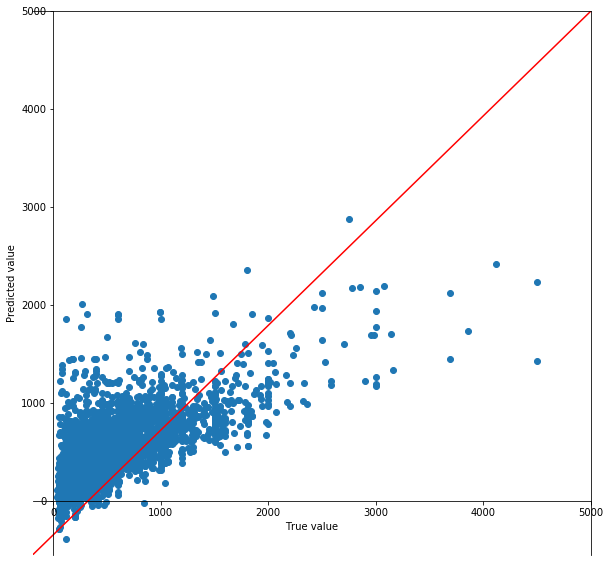

In [818]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(y_hold, y_hold_pred)
ax.set_yticks(range(0, 6000, 1000))
ax.set_xticks(range(0, 6000, 1000))
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
plt.xlabel('True value')
plt.ylabel('Predicted value')
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
plt.show()

## LGBM

In [819]:
lgbm=LGBMRegressor(objective='gamma', n_estimators=100, max_depth=4)

In [820]:
lgbm.fit(x_train, y_train)

LGBMRegressor(max_depth=4, objective='gamma')

In [821]:
y_train_pred = lgbm.predict(x_train)
y_test_pred = lgbm.predict(x_test)
y_hold_pred = lgbm.predict(x_hold)

* Desvio

In [822]:
mean_gamma_deviance(y_train, lgbm.predict(x_train))

0.25834155012139387

In [823]:
mean_gamma_deviance(y_test, lgbm.predict(x_test))

0.2785821230745414

In [824]:
mean_gamma_deviance(y_hold, lgbm.predict(x_hold))

0.28477222694368703

* MRAE

In [825]:
mean_absolute_percentage_error(y_hold, y_hold_pred)

0.5912779631493571

* RMSE

In [826]:
np.sqrt(mean_squared_error(y_hold, y_hold_pred))

288.8485603186728

Gráfico real x predito

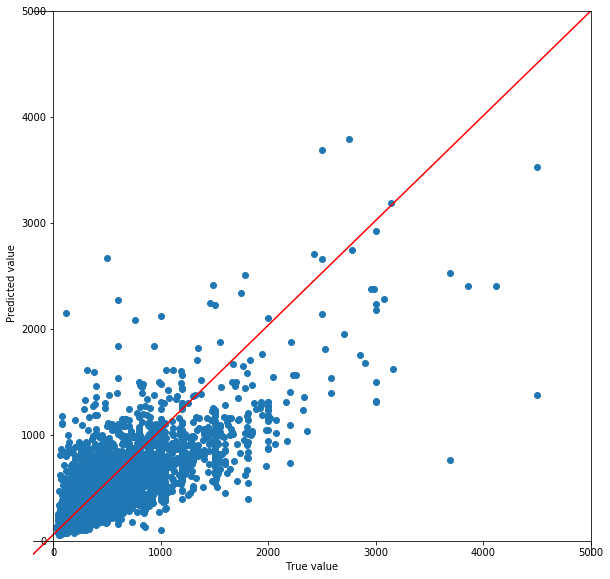

In [827]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(y_hold, y_hold_pred)
ax.set_yticks(range(0, 6000, 1000))
ax.set_xticks(range(0, 6000, 1000))
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
plt.xlabel('True value')
plt.ylabel('Predicted value')
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
plt.show()

# Considerações finais

O modelo LGBM se comportou melhor do que a regressão linear (feita para fins ilustrativos pois ela fornece valores negativos que não fazem sentido para este caso). O modelo LGBM utiliza distribuição gamma, restringindo o preço a valores positivos. Ele tem um MRAE de 59,1 % e RMSE de 288,8, o que indica que a disperção é alta, especialmente para valores de preço mais altos.